## This is the playground to test and develop

### itebd

In [32]:
# in order to use CuPy

# import cupy as np
# import matplotlib.pyplot as plt
# from cupyx.scipy.linalg import expm
# from cupy.linalg import svd
# # cupy.ndarray.get() to convert it to an np.ndarray


In [33]:
from opt_einsum import contract as oeinsum

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, svd
import quimb as qu
import warnings

class IMPS:
    def __init__(self, d, chi):

        # initializing the dimension of the local hilbert space: spin 1 sites --> d = 3
        # initializing the maximum bond dimension chi. 2 is enough for the AKLT model.
        # bond dimension is not dynamic and will not change in this code but we can implement that as well.
        # we have 2 sites only which are repeated indefinitely. we call them L and R and we initialize them randomly.
        # I am considering the L and R as kets here

        self.d = d
        self.chi = chi
        self.spin = (self.d-1)*1/2
        self.Sx, self.Sy, self.Sz = self.spin_ops()
        self.L = np.random.randn(chi, d, chi) + 1j * np.random.randn(chi, d, chi)
        self.R = np.random.randn(chi, d, chi) + 1j * np.random.randn(chi, d, chi)

        self.L /= np.linalg.norm(self.L)
        self.R /= np.linalg.norm(self.R)
        self.U = None

    def spin_ops(self):

        # spin operators are 3 by 3 matrices here. we import them from quimb.

        Sx = qu.spin_operator('x', self.spin)
        Sy = qu.spin_operator('y', self.spin)
        Sz = qu.spin_operator('z', self.spin)

        return Sx, Sy, Sz
    
    def aklt_2site_hamiltonian(self):
        Sx, Sy, Sz = self.Sx, self.Sy, self.Sz
        
        # we are just doing a tensor product and summing to get the first term in the Hamiltonian
        # we could also use np.kron here but this gives us a chance to see how the indices are being manipulated
        # look at the first term of the SdotS. note that i and k are kets of the operator Sx for site L and j and l are the bras of the operator Sx for site R
        # we put i next to k and j next to l so that we can keep track of how we are contracting them
        # the result is a 3 by 3 by 3 by 3 by 3 matrix. reshaping this into a 9 by 9 matrix just gives us Sx_L ⊗ Sx_R

        SdotS = (
        np.einsum('ij,kl->ikjl', Sx, Sx) +
        np.einsum('ij,kl->ikjl', Sy, Sy) +
        np.einsum('ij,kl->ikjl', Sz, Sz)
        )

        SdotS = SdotS.reshape(self.d**2, self.d**2)

        # now we need to add the second term to the Hamiltonian.
        H = SdotS + 1/3 * SdotS@SdotS


        # this is what the hamiltonian should look like, although as a 9 by 9 matrix and not in the MPO form
        # we might need to reshape it later, but we can exponentiate rank 2 matrices so we return it as a matrix

        return H
    
    def time_evolution_operator(self, dt, imaginary=True):

        # we exponentiate and reshape to get a time evolution operator U which has 4 indices
        # the first two are kets corresponding to each site and the last two are bras and can be contracted with the kets

        H = self.aklt_2site_hamiltonian()
        if imaginary:
            U = expm( -dt * H )
        else:
            U = expm(-1j * dt * H)
        return U.reshape(self.d, self.d, self.d, self.d)
    
    def contract_and_evolve(self, dt, steps):
        U = self.time_evolution_operator(dt)
        self.U = U
        enpb = []


        
        for _ in range(steps):

            # for each step, we contract the L and R over their bond, leaving us with a tensor of shape (chi, d, d, chi)
            # this is necessary because the time evoolution operator acts on pairs of neighboring sites
            LR = np.einsum('ijk,klm->ijlm', self.L, self.R)


            # we then contract this with the time evolution operator U. note that the bras of U __k,l__ are contracted with the kets of LR, also named __k,l__. leaving a,i,j,b untouched
            LR = np.einsum('ijkl,aklb->aijb', U, LR)


            # in this step we apply svd and truncate with the same chi. this is undoing what we did in the first step.
            u, s, v = svd(LR.reshape(self.chi * self.d, self.chi * self.d))

            u = u[:, :self.chi]
            s = s[:self.chi]
            v = v[:self.chi, :]
            
            sqrt_s = np.diag(np.sqrt(s))
            u_combined = u @ sqrt_s
            v_combined = sqrt_s @ v

            self.L = u_combined.reshape(self.chi, self.d, self.chi)
            self.R = v_combined.reshape(self.chi, self.d, self.chi)

            # just computing the energy per pair of sites here
            enpb.append(self.compute_energy_per_bond(self.aklt_2site_hamiltonian().reshape(self.d, self.d, self.d, self.d)))

        return enpb
    
    def compute_energy_per_bond(self, H):


        # this is also a nice example of how np.einsum works.
        # we get the LR just like we did before but we call it the ket here
        # we get the bra as the conjugate of the ket

        ket = np.einsum('iaj,jbk->iabk', self.L, self.R)
        bra = np.conj(ket)


        # the hamiltonian here is 3 by 3 by 3 by 3 and we need to contract it with the ket and bra. just as we get the expectation value
        # the kets of H: ij, the bras of H: kl. so these indices are contracted with the indices of the bra of and the ket respectively which have the same names
        # finally we have the a and b which are the bond indices. these indices contract with themselves and we get a scalar


        numerator = np.einsum('aijb,ijkl,aklb->',bra, H, ket)
        norm = np.einsum('ijab,ijab->', bra, ket)

        return np.real(numerator / norm)
    




if __name__ == "__main__":


    d = 3
    chi = 2 # higher chi makes no difference, chi = 1 messes up the simulation
    tau = 0.01
    steps = 5000


    mps = IMPS(d, chi)
    H2 = mps.aklt_2site_hamiltonian()

    energies_after_each_step = mps.contract_and_evolve(tau, steps)        

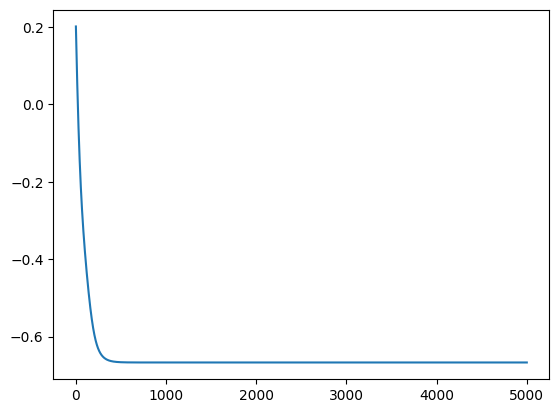

In [136]:
plt.plot(energies_after_each_step) #imaginay time gives us the pretty exponential decay

In [137]:
energies_after_each_step[-1] # this should be the ground state energy per bond afaik. I am not sure about this though.

np.float64(-0.666666666666667)

### tebd(finite N, alternating local updates)

In [69]:
class TNet():


    def __init__(self, N, spin=1, chi=2, max_bond_dim=20):

        self.N = N
        self.spin = spin
        self.d = int(2 * self.spin + 1)
        self.chi = chi
        self.max_bond_dim = max_bond_dim
        self.norm = None

        L = np.random.randn(1, self.d, self.chi) + 1j * np.random.randn(1, self.d, self.chi)
        R = np.random.randn(self.chi, self.d, 1) + 1j * np.random.randn(self.chi, self.d, 1)
        L /= np.linalg.norm(L)/np.sqrt(self.chi)
        R /= np.linalg.norm(R)

        self.MPS = []
        self.MPS.append(L)
        for _ in range(N-2):
            randomized_site = np.random.randn(self.chi, self.d, self.chi) + 1j * np.random.randn(self.chi, self.d, self.chi)
            randomized_site /= np.linalg.norm(randomized_site)/np.sqrt(self.chi)
            self.MPS.append(randomized_site)
        self.MPS.append(R)
        self.get_norm()
        
        self.H = None
        self.U = None
        self.Sx, self.Sy, self.Sz = self.spin_ops()
        self.CHIs = self.chi*np.ones(self.N-1, dtype=int)



    def spin_ops(self):
        Sx = qu.spin_operator('x', self.spin)
        Sy = qu.spin_operator('y', self.spin)
        Sz = qu.spin_operator('z', self.spin)

        return Sx, Sy, Sz



    def make_left_canonical(self, bond=0, mode = 'qr', verbose=False):
        
        if bond < 0 or bond >= self.N - 1:
            raise ValueError(f"Bond index {bond} out of range. Must be between 0 and {self.N - 2}(inclusive).")

        A = self.MPS[bond]
        B = self.MPS[bond + 1]
        chiL, d, chiB = A.shape
        _, _, chiR = B.shape

        if mode == 'qr':
            
            Q, R = np.linalg.qr(A.reshape(chiL * d, chiB), mode='reduced')
            chi_new = R.shape[0]

            A_new = Q.reshape(chiL, d, chi_new)
            B_new = np.einsum('ij,jkl->ikl', R, B).reshape(chi_new, d, chiR)
            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new
            
            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond dimension {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        elif mode == 'svd':

            u, s, vh = svd(A.reshape(chiL * d, chiB), full_matrices=False)
            chi_new = min(self.max_bond_dim, len(s))
            if chi_new < len(s):
                discarded_weight = np.sum(s[chi_new:]**2)
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(s)}. \nDiscarded weight: {discarded_weight:.4f}.\nIncrease max_bond_dim if needed."
                warnings.warn(message, UserWarning)

            u = u[:, :chi_new]
            s = s[:chi_new]
            vh = vh[:chi_new, :]

            svh = np.diag(s) @ vh

            A_new = u.reshape(chiL, d, chi_new)
            B_new = np.einsum('ij,jkl->ikl', svh, B).reshape(chi_new, d, chiR)
            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'qr' or 'svd'.")



    def is_left_canonical(self, site=0, all=False):
            
            if all:
                left_can_list = [self.is_left_canonical(s, all=False) for s in range(self.N-1)]
                return left_can_list

            A = self.MPS[site]
            chiL, d, chiR = A.shape
            A = A.reshape(chiL * d, chiR)

            mat = A.T.conj()@A
            identity = np.eye(len(mat))

            return np.allclose(mat, identity)



    def sweep_right(self, start = 0, end=None, mode='qr'):
        
        if end is None:
            end = self.N - 1

        for bond in range(start, end):
            self.make_left_canonical(bond, mode=mode, verbose=False)



    def make_right_canonical(self, bond=None, mode='qr', verbose=False):

        if bond is None:
            bond = self.N - 2

        if bond < 0 or bond >= self.N - 1:
            raise ValueError(f"Bond index {bond} out of range. Must be between 0 and {self.N - 2}(inclusive).")

        A = self.MPS[bond]
        B = self.MPS[bond + 1]
        chiL, d, chiB = A.shape
        _, _, chiR = B.shape

        if mode == 'qr':
            B_reshaped = B.reshape(chiB, d * chiR).T
            Q, R = np.linalg.qr(B_reshaped, mode='reduced')

            chi_new = Q.shape[1]
            B_new = Q.T.reshape(chi_new, d, chiR)
            A_new = np.einsum('aib,bc->aic', A, R.T).reshape(chiL, d, chi_new)

            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond dimension {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        elif mode == 'svd':
            B_reshaped = B.reshape(chiB, d * chiR)
            u, s, vh = svd(B_reshaped, full_matrices=False)

            chi_new = min(self.max_bond_dim, len(s))
            if chi_new < len(s):
                discarded_weight = np.sum(s[chi_new:] ** 2)
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(s)}.\nDiscarded weight: {discarded_weight:.4f}."
                warnings.warn(message, UserWarning)

            u = u[:, :chi_new]
            s = s[:chi_new]
            vh = vh[:chi_new, :]

            B_new = vh.reshape(chi_new, d, chiR)
            left_piece = u @ np.diag(s)

            A_new = np.einsum('aib,bc->aic', A, left_piece).reshape(chiL, d, chi_new)

            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'qr' or 'svd'.")
    


    def is_right_canonical(self, site=0, all=False):

        if all:
            right_can_list = [self.is_right_canonical(s, all=False) for s in range(self.N-1)]
            return right_can_list
        
        else:
            A = self.MPS[site]
            chiL, d, chiR = A.shape
            A = A.reshape(chiL, d* chiR)

            mat = A@A.T.conj()
            identity = np.eye(len(mat))

            return np.allclose(mat, identity)
    


    def find_center(self):
        """this is implemented improperly. use with caution"""

        lcl = self.is_left_canonical(all=True)
        rcl = self.is_right_canonical(all=True)
        which = np.array([lcl[i] or rcl[i] for i in range(len(lcl))])
        if len(which[which == False]) == 1:
            center = np.argmin(which)
            return center
        else:
            message = "The MPS is not centered"
            warnings.warn(message,UserWarning)



    def sweep_left(self, start=None, end=None, mode='qr'):

        if start is None:
            start = self.N - 2
        if end is None:
            end = -1

        for bond in range(start, end, -1):
            self.make_right_canonical(bond, mode=mode, verbose=True)



    def get_norm(self, mode='transfer_matrix', normalize=False):


        if mode == 'transfer_matrix':

            left_env = np.array([[1.0]])

            for i in range(self.N - 1):
                A = self.MPS[i]
                Ac = np.conj(A)
                # left_env = np.einsum('ab,aix,biy->xy', left_env, A, Ac)

                left_env = np.tensordot(left_env, A, axes=(0, 0))
                left_env = np.tensordot(left_env, Ac, axes=([0,1],[0,1])) 

            self.norm = np.sqrt(np.abs(left_env[0, 0]))

            if normalize:
                for i in range(self.N):
                    self.MPS[i] /= self.norm**(1/self.N)
                if self.get_norm(mode='transfer_matrix', normalize=False) - 1 > 1e-6:
                    warnings.warn("Normalization failed. The norm is not close to 1.", UserWarning)
            return self.norm

        elif mode == 'sweep_first':
            
            self.sweep_right()
            last = self.MPS[-1]
            last_c = np.conj(last)

            self.norm = np.sqrt(np.abs(np.einsum('aib,aib->', last, last_c)))

            if normalize:
                self.MPS[-1] /= self.norm
                if self.get_norm(mode='transfer_matrix', normalize=False) - 1 > 1e-6:
                    warnings.warn("Normalization failed. The norm is not close to 1.", UserWarning)

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'transfer_matrix' or 'sweep_first'.")

        return self.norm
    


    def aklt_2site_hamiltonian(self):

        Sx, Sy, Sz = self.Sx, self.Sy, self.Sz
        
        SdotS = (
        np.einsum('ij,kl->ikjl', Sx, Sx) +
        np.einsum('ij,kl->ikjl', Sy, Sy) +
        np.einsum('ij,kl->ikjl', Sz, Sz)
        )

        SdotS = SdotS.reshape(self.d**2, self.d**2)

        H = SdotS + 1/3 * SdotS@SdotS

        return H



    def time_evolution_operator(self, dt, Ham = None, imaginary=True):

        if Ham is None and self.H is None:
            self.H = self.aklt_2site_hamiltonian()
            Ham = self.H

        elif Ham is None and self.H is not None:
            Ham = self.H

        if imaginary:
            self.U = expm( -dt * Ham ).reshape(self.d, self.d, self.d, self.d)
        else:
            self.U = expm(-1j * dt * Ham).reshape(self.d, self.d, self.d, self.d)


        return self.U
            


    def update(self, bond, U, imaginary=True, dyn_bond=False):

        A = self.MPS[bond]
        B = self.MPS[bond+1]

        AB = np.einsum('aib,bjc->aijc', A, B) 
        
        chiA, d1, d2, chiB = AB.shape

        bond_check_left = self.CHIs[bond -1] if bond > 0 else 1
        bond_check_right = self.CHIs[bond + 1] if bond < self.N - 2 else 1
        if dyn_bond:
            err = (chiA == bond_check_left) and (chiB == bond_check_right)
            if not err:
                raise ValueError(f"Bond dimension mismatch at bond {bond}: expected ({bond_check_left}, {bond_check_right}), got ({chiA}, {chiB})")
            

        if self.U is None and U is None: U = self.time_evolution_operator(dt = 0.01, imaginary=imaginary)

        AB = np.einsum('ijkl,aklb->aijb', U, AB)


        AB = AB.reshape(chiA * d1, d2 * chiB)

        Umat, S, Vh = np.linalg.svd(AB, full_matrices=not dyn_bond)
        if (not dyn_bond) and len(Umat) < (self.chi):
            raise ValueError(f"Bond dimension {bond} is too big for the current MPS. Use dynamic bond dimensison or choose a smaller fixed bond dimension.")

        chi_new = self.chi
        if dyn_bond:
            chi_new = min(self.max_bond_dim, len(S))
            self.CHIs[bond] = chi_new
        if chi_new < len(S):
            discarded_weight = np.sum(S[chi_new:]**2)
            if discarded_weight > 5e-3:
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(S)}. \nDiscarded weight: {discarded_weight:.4f}.\nIncrease max_bond_dim or use a shorter time step if needed."
                warnings.warn(message, UserWarning)

        Umat = Umat[:, :chi_new]
        S = S[:chi_new]
        Vh = Vh[:chi_new, :]

        sqrtS = np.sqrt(S)
        Umat = Umat @ np.diag(sqrtS)
        Vh = np.diag(sqrtS) @ Vh

        A_new = Umat.reshape(chiA, d1, chi_new)
        B_new = Vh.reshape(chi_new, d2, chiB)

        
        self.MPS[bond] = A_new
        self.MPS[bond+1] = B_new



    def trotterize(self, full_U, half_U, imaginary=True, dyn_bond=False):

        Bonds = np.arange(self.N-1)
        eBonds = Bonds[Bonds % 2 == 0]
        oBonds = Bonds[Bonds % 2 == 1]

        for bond in eBonds:  self.update(bond, half_U, imaginary=imaginary, dyn_bond=dyn_bond)
        for bond in oBonds: self.update(bond, full_U, imaginary=imaginary, dyn_bond=dyn_bond)
        for bond in eBonds: self.update(bond, half_U,imaginary=imaginary, dyn_bond=dyn_bond)



    def evolve(self, dt, steps, imaginary=True, dyn_bond=False, make_canonical_every=0):

        full_U = self.time_evolution_operator(dt=dt, imaginary=imaginary)
        half_U = self.time_evolution_operator(dt=dt/2, imaginary=imaginary)
        for i in range(steps):
            self.trotterize(full_U, half_U, imaginary=imaginary, dyn_bond=dyn_bond)
            if make_canonical_every > 0:
                if i % make_canonical_every == 0:
                    self.get_norm(mode='sweep_first', normalize=True)



    def expectation_2site(self, bond, operator=None, mode='brute_force'):

        if operator is None:
            operator = self.aklt_2site_hamiltonian().reshape(self.d, self.d, self.d, self.d)


        if mode == 'brute_force':
                
            left_env = np.array([[1.0]])

            for i in range(bond):
                a = self.MPS[i]
                aconj = np.conj(a)

                left_env = np.tensordot(left_env, a, axes=(0, 0))
                left_env = np.tensordot(left_env, aconj, axes=([0,1],[0,1]))

            A = self.MPS[bond]
            B = self.MPS[bond + 1]
            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)
        
            bond_ex_val = np.einsum('aijc,ijkl,bkld->abcd', bra, operator, ket)
            left_env = np.einsum('ab,abcd->cd', left_env, bond_ex_val)

            for i in range(bond+1, self.N-1):
                A = self.MPS[i]
                Ac = np.conj(A)

                left_env = np.tensordot(left_env, A, axes=(0, 0))
                left_env = np.tensordot(left_env, Ac, axes=([0,1],[0,1]))

            expectation_value = np.real(left_env[0, 0])

        elif mode == 'center_first':

            self.sweep_right(end=bond, mode='qr')
            self.sweep_left(end =bond, mode='qr')
            
            self.MPS[bond]/= self.norm
            self.MPS[bond + 1]/= self.norm

            A = self.MPS[bond]
            B = self.MPS[bond + 1]

            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)

            expectation_value = np.einsum('aijb,ijkl,aklb->', bra, operator, ket)
            expectation_value = np.real(expectation_value)

            self.get_norm(mode='sweep_first', normalize=False)

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'brute_force' or 'center_first'.")

        return expectation_value
    


    def total_energy(self, H=None):

        if H is None:
            if self.H is None:
                self.H = self.aklt_2site_hamiltonian()
            H = self.H

        H = H.reshape(self.d, self.d, self.d, self.d)

        energy = 0

        self.sweep_left(mode='qr')
        

        for bond in range(self.N-1):
            self.make_left_canonical(bond=bond, mode='qr')

            A = self.MPS[bond]
            B = self.MPS[bond + 1]

            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)

            expectation_value = np.einsum('aijb,ijkl,aklb->', bra, H, ket)
            expectation_value = np.real(expectation_value)
            
            energy += expectation_value

        self.get_norm(mode='sweep_first', normalize=True)
        return energy



In [155]:
obj = TNet(N = 20000, spin = 1, chi = 2, max_bond_dim=2)
obj.evolve(dt=0.02, steps=600, imaginary=True, dyn_bond=True, make_canonical_every=1)
total_energy = obj.total_energy()
print(f"Total energy: {total_energy}")

Total energy: -13332.666285052732


In [156]:
total_energy/(obj.N - 1)

np.float64(-0.6666666475850158)

#### to be added

- convergence criteria
- first excited state
- parallelization
- check for bugs/ special cases
- entropy
- look into DMRG
- total_spin_analysis_full_space
